# Fitting a Hologram

This notebook shows how to load pre-recorded holograms colloidal spheres
into a **Frame** object and analyze them with Lorenz-Mie theory. The analysis 
detects all of the spheres in the field of view and yields values for each
spheres radius, refractive index and three-dimensional location, together with
error estimates for each value.

In [8]:
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.patches import Rectangle
import numpy as np
import cv2

# import cupy # Uncomment to use GPU acceleration
from pylorenzmie.analysis import Frame

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## Framework for Lorenz-Mie analysis
First, we instantiate a **Frame** object. By default, **Frame** analyzes features with 
the standard Lorenz-Mie model for hologram formation. The model includes a representation of the instrument that records the images we wish to analyze. In this example, we specify that the instrument is an in-line holographic microscope that illuminates the sample with blue light at a vacuum wavelength of $\lambda$ = 0.447 μm and has a system magnification of 0.048 μm/pixel. We will be analyzing holograms of colloidal spheres dispersed in water. The refractive index of the medium therefore is $n_m$ = 1.340 at the imaging wavelength. These calibration constants may differ for different hardware implementations. The commercial xSight instrument, for example, uses a system magnification of 0.120 μm/pixel.

In [2]:
configuration = dict(wavelength = 0.447,    # [um]
                     magnification = 0.048, # [um/pixel]
                     n_m = 1.34, 
                     distribution = 'radial',
                     percentpix = 0.2,
                     pupil=640.)

frame = Frame(**configuration)

We also will want to report the results of our hologram analysis. Here's a handy helper function:

In [3]:
def report(frame):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(frame.data, cmap='gray')
    ax.scatter(frame.results.x_p, frame.results.y_p, c='r')
    for bbox in frame.bboxes:
        ax.add_patch(Rectangle(*bbox, fill=False, ec='r'))
    display(frame.results)

## Read in holographic microscopy data
Next, we load the hologram that we wish to analyze. The Frame() object expects a normalized hologram whose background intensity value is 1. Our example holograms are stored as PNG images with the background value set to 100. We use OpenCV to read them in as single-channel grayscale images, convert them to floating-point arrays and then normalize them.

In [14]:
data = cv2.imread('tutorials/PS_silica.png', 0).astype(float) / 100

## Analyze the normalized hologram with Frame()

,x_p,dx_p,y_p,dy_p,z_p,dz_p,a_p,da_p,n_p,dn_p,success,npix,redchi
0,376.177,0.027,481.956,0.026,178.741,0.226,0.784,0.002,1.55,6.413e-04,True,5056,4.672


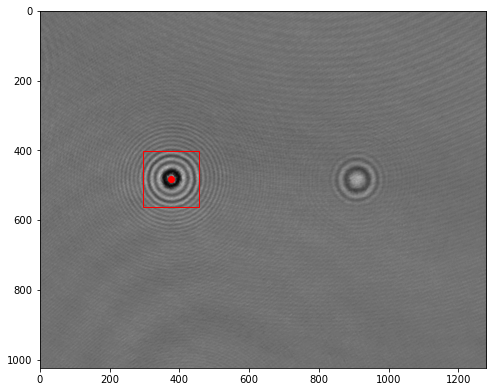

In [15]:
frame.analyze(data)
report(frame)

## Troublesome holograms

Sometimes, automated fits to holograms do not work out correctly, typically
because the optimizer locks on to a local minimum in the error surface rather
than finding the globally optimal solution. There are at least two approaches
to overcoming this problem:
1. using prior knowledge
2. using robust fitting

As an example, this is a hologram of a pair of silica spheres in water, each 
nominally 2 µm in diameter. The fitter appears to lock on nicely, but the 
results for the radius and refractive index are incorrect.
We know that something is amiss because the reduced chi-square statistic is signifiantly
larger than 1.

,x_p,dx_p,y_p,dy_p,z_p,dz_p,a_p,da_p,n_p,dn_p,success,npix,redchi
0,927.455,292.209,726.322,184.981,402.75,822.444,1.109,2.027,1.339,0.028,True,17169,47.479
1,1181.784,230.712,528.171,243.395,645.69,1081.067,2.543,3.267,1.340,0.003,True,18120,42.457


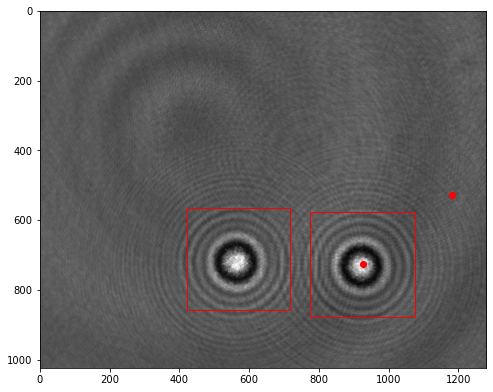

In [11]:
data = cv2.imread('tutorials/image0010.png', 0).astype(float)
data /= np.median(data)
frame.analyze(data)
report(frame)

The problem is likely to be that the automated parameter estimator is providing
initial estimates that are too far from the ground truth for the optimizer to 
identify the globally optimal solution. 

## Reanalyze data with robust estimation

Adding <tt>robust=True</tt> to the Frame's configuration informs the
optimizer to minimize the absolute deviations rather than the squared deviations.
This makes the optimization less sensitive to outliers, such as the pixels
in the overlapping interference patterns between the two particles.

,x_p,dx_p,y_p,dy_p,z_p,dz_p,a_p,da_p,n_p,dn_p,success,npix,redchi
0,922.064,2.710,724.442,1.624,391.430,7.828,1.101,0.026,1.410,1.322e-02,True,17169,2.444
1,918.978,0.142,732.599,0.133,354.246,0.885,1.211,0.006,1.376,5.166e-04,True,18120,1.983


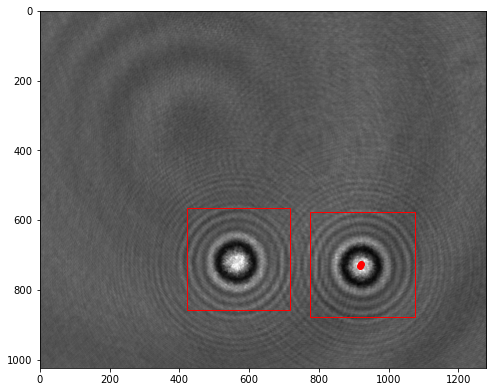

In [12]:
configuration = dict(wavelength = 0.447,    # [um]
                     magnification = 0.048, # [um/pixel]
                     n_m = 1.34, 
                     distribution = 'radial',
                     percentpix = 0.2,
                     robust = True
                     )

robust_frame = Frame(**configuration)
data = cv2.imread('tutorials/image0010.png', 0).astype(float)
data /= np.median(data)
robust_frame.analyze(data)
report(robust_frame)